# Проект "Определение стоимости автомобилей" 

---

# Описание исследования

---
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

---

# Цель исследования

---

Провести анализ данных, полученных от заказчика. Выявить закономерности и отфильтровать эти данные. На основании предобработанных данных создать модель МО, которая сможет предсказывать стоимость автомобиля. 

---

# Задачи исследования

---

Провести предобработку данных. Посмотреть данные на наличие дубликатов и пропущенных значений. Выполнить исследовательский анализ, для определения аномальных значений и выбросов. Посмотреть как распределяются наши признаки. Отсеять лишние признаки на основе корреляционного анализа. Аналетически выявить признаки, которые являются неинформативными при обучении модели. На основе предобработанных данных сформировать обучающую и тестовые выборки, которые необходимы для обучения моделей. Обучить модели различными способами. Проанализировать полученные модели и выбрать лучшую, на основании предпочтений заказчика.

---

# Исходные данные

---

Для проведения исследования и создания модели заказчик передал нам CSV-файл с данными о машинах, которые фигурируют в базе в данный момент: ***autos.csv***

---

# Введение

---

**Часть 1. Подготовка данных**

- 1. [Установка и импортирование библиотек](#section_1)
- 2. [Выгрузка и первичный осмотр данных](#section_2)
- 3. [Обработка пропусков](#section_3)
- 4. [Исследовательский анализ данных](#section_4)
- 5. [Проверка на дубликаты](#section_5)
- 6. [Корреляционный анализ](#section_6)

**Часть 2. Обучение моделей**

- 1. [Формирование выборок](#section_7)
- 2. [Создание пайплайна](#section_8)
- 3. [Обучение моделей](#section_9)

**Часть 3. Анализ моеделей**

- 1. [Сравнение полученных моделей](#section_10)

## Подготовка данных

<a id='section_1'></a>

### Установка и импортирование библиотек 

In [1]:
!pip install phik -q
!pip install -U scikit-learn -q

In [2]:
#Импорт библиотек:

#Библиотеки для работы с табличными данными и массивами:
import pandas as pd
import numpy as np

#Библиотеки для графической иллюстрации:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

#Библиотеки для корреляционного анализа:
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#Инструменты для создания пайплайнов:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Класс для работы с пропусками
from sklearn.impute import SimpleImputer

#Библиотеки для масштабирования и кодирования данных:
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler)

#Библиотеки для масштабирования данных:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Модели МО:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#Библиотеки для создания выборок:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Библиотеки для метрик:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, make_scorer

#Иморт библиотеки дял градиентного бустинга:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings

from time import time

#Константы:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
#Пытаемся выгрузить данные с сети:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    
#Если сети - нет, выгружаем локально:
except:
    df = pd.read_csv('/datasets/autos.csv')
    
#Используем специальную команду отображения таблиц, для наглядного просмотра всех данных:    
pd.set_option('display.max_columns', None)

<a id='section_2'></a>

### Выгрузка и первичный осмотр данных

In [4]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

> Датафрейм содержит **16** признаков и **354369** наблюдений

> В данных есть пропуска - их нужно просмотреть и обработать

> Все значения в столбцах соответвуют типам данных, кроме временных полей (***DateCrawled, DateCreated, LastSeen***)

Исходное признаковое пространство:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро) | **Целевой признак**

**Признаки, которые являются неиформативными (нужно удалить):**

1. DateCrawled - дата, когда скачали анкету из базы - никак не влияет на цену авто

2. DateCreated - аналогично, дата, создания анкеты - не должна влиять на цену

3. LastSeen - дата последней активности пользователя - также излишний признак

(По сути убираем все временные переменные из таблицы)

**Признаки, которые малоинформативны, но возможно будут вносить свои веса в модели (под рассмотрением):**

1. RegistrationYear и RegistrationMonth - два признака, которые будут мешать друг другу, требуется один удалить (оставим год регистрации, месяц не нужен)

2. NumberOfPictures - сомнительный признак, но возможно у покупателя возникает большее желание купить авто, если имеется большее количество фотографий, нежели маленькое (лучше удалить)

3. PostalCode - может иметь косвенное влияние через региональные особенности цен, но скорее всего слабый признак (удаляем)

**Признаки, которые требуется оставить, являются информативными:**

Остальные признаки являются техническими характеристиками транспортного средства, они напрямую влияют на цену, т.е. на целевую переменную

In [6]:
#Удаление неинформативных признаков:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures'], axis=1)

In [7]:
#Теперь датафрейм принял вид:
df.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


<a id='section_3'></a>

### Обработка пропусков

In [8]:
#Просмотрим пропуска
pd.DataFrame(df.isna().mean()*100).sort_values(by=0, ascending=False).style.background_gradient('coolwarm')

,0
Repaired,20.079070
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000
Brand,0.000000


In [9]:
df['Repaired'].value_counts()

no     247161
yes     36054
Name: Repaired, dtype: int64

- Пропуска в столбце Repaired заменим на unknown:

In [10]:
df['Repaired'] = df['Repaired'].fillna('unknown')

df['Repaired'].value_counts()

no         247161
unknown     71154
yes         36054
Name: Repaired, dtype: int64

- Пропуска в столбцах VehicleType, FuelType, Gearbox - заменим модой на этапе создания пайплайна

In [11]:
df['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [12]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [13]:
df['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

- Пропуска в Model добавим в категорию other

In [14]:
df['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [15]:
df['Model'] = df['Model'].fillna('other')

df['Model'].value_counts()

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

<a id='section_4'></a>

###  Исследовательский анализ данных

#### Функция check

Данную функцию создаем для проверки, чтобы не удалить больше данных, чем можем. Процент данных, который мы можем потерять, составляет **не более 10%** данных от изначального числа

In [16]:
#Создадим глобальную переменную, в которой сохраним размер строк исходного ДФ:
rows_df = df.shape[0]

#Определим функцию, которая возращает процент пропусов по столбцам и количество удаленных строк:
def check():
    perc2 = ((rows_df - df.shape[0])/rows_df)*100
    #выводим процент удаленных строк:
    print(f'Процент данных, который мы срезали: {perc2:.2f}%')
    pass

#Вызовем функцию сheck:
check()

Процент данных, который мы срезали: 0.00%


#### Анализ количественных признаков


Статистические характеристики признака Price


count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Мода признака Price: 0



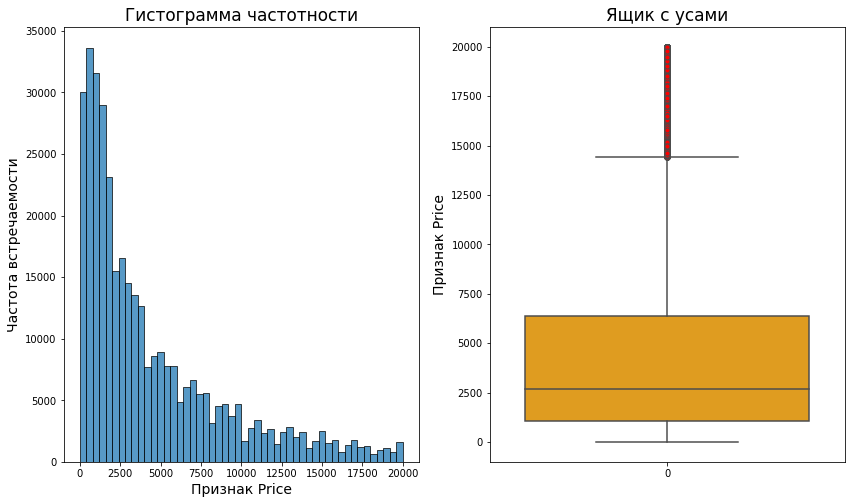


Статистические характеристики признака RegistrationYear


count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Мода признака RegistrationYear: 2000



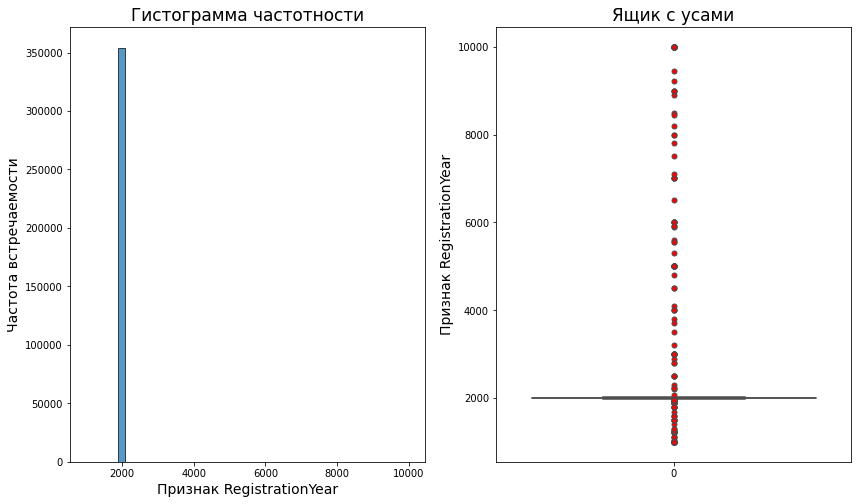


Статистические характеристики признака Power


count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Мода признака Power: 0



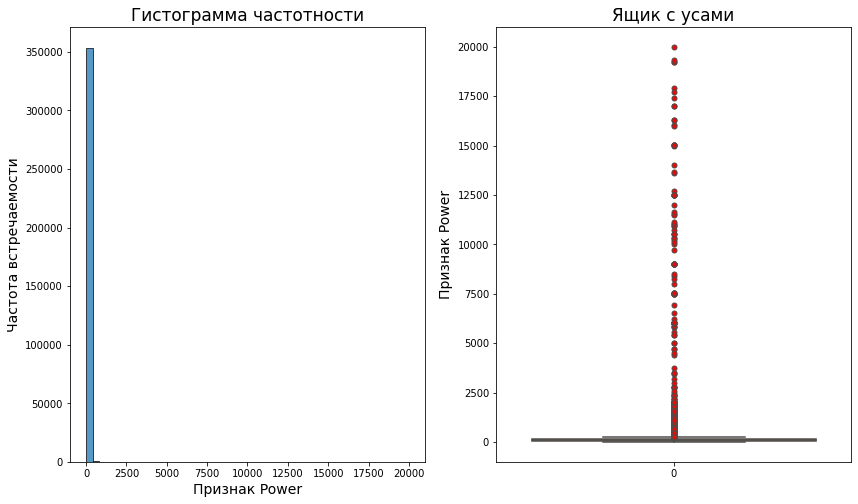


Статистические характеристики признака Kilometer


count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Мода признака Kilometer: 150000



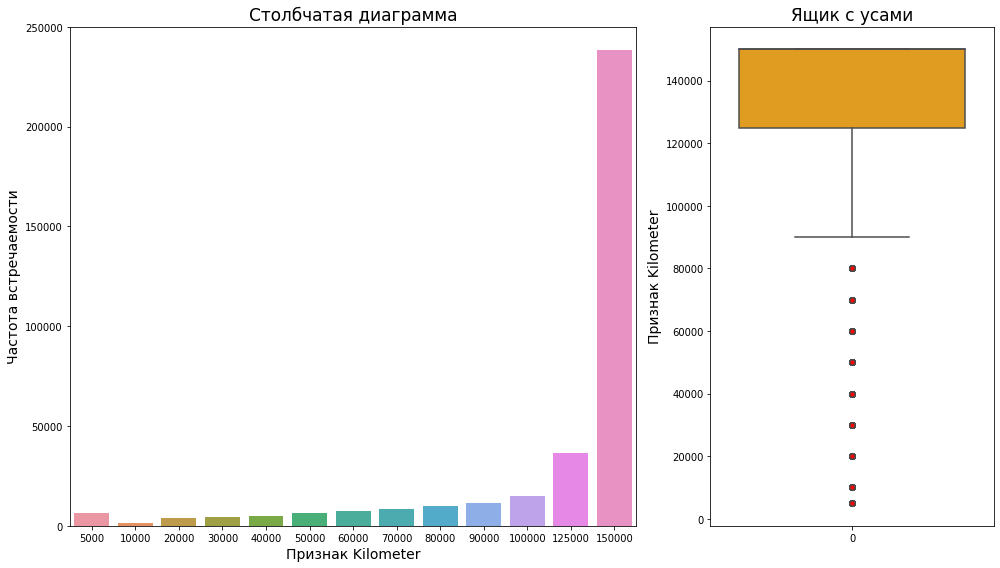

In [17]:
#Создадим функцию для построения частотных гистограмм и боксплотов для количественных переменных:
def analysis_num(df, bins):
    
    #Перебираем все имена с количественными столбцами:
    for name in df.select_dtypes(include='number').columns.tolist()[:-1]:
        
        #Статистические характеристики по столбцу:
        print()
        print(f'Статистические характеристики признака {name}')
        display(df[name].describe())        
        print(f'Мода признака {name}: {df[name].mode()[0]}')
        print()
            
        #Строим гистограммы в цикле:
        fig, axes = plt.subplots(1, 2, figsize=(14,8))        
        sns.histplot(data=df[name], linewidth=0.7, bins=bins, ax=axes[0])        
        axes[0].set_title('Гистограмма частотности', fontsize=17)
        axes[0].set_xlabel(f'Признак {name}', fontsize=14)
        axes[0].set_ylabel('Частота встречаемости', fontsize=14)        
       
        #Строим боксплоты в цикле:       
        sns.boxplot(data=df[name], color='orange', flierprops=dict(marker='o', markerfacecolor='red', markersize=5), ax=axes[1])
        axes[1].set_title('Ящик с усами', fontsize=17)
        axes[1].set_ylabel(f'Признак {name}', fontsize=14)
        plt.show()
    
    
    print()
    print(f'Статистические характеристики признака Kilometer')
    display(df['Kilometer'].describe())        
    print(f"Мода признака Kilometer: {df['Kilometer'].mode()[0]}")
    print()
    
    # Создаем основную фигуру
    fig = plt.figure(figsize=(14, 8))

    gs = GridSpec(1, 2, width_ratios=[2, 1])  # Задаем разные соотношения ширины

    ax0 = fig.add_subplot(gs[0])
    sns.countplot(x='Kilometer', data=df, ax=ax0)
    ax0.set_title('Столбчатая диаграмма', fontsize=17)
    ax0.set_xlabel(f'Признак Kilometer', fontsize=14)
    ax0.set_ylabel('Частота встречаемости', fontsize=14)

    ax1 = fig.add_subplot(gs[1])
    sns.boxplot(data=df['Kilometer'], color='orange', 
                flierprops=dict(marker='o', markerfacecolor='red', markersize=5), ax=ax1)
    ax1.set_title('Ящик с усами', fontsize=17)
    ax1.set_ylabel(f'Признак Kilometer', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
#Вызовем функцию для первого датафрейма: (количество корзин можно менять, если потребуется)
analysis_num(df, 50)

> Итак, во всех признаках **имеются выбросы**, но некоторые из них лежат в разумном диапозоне

> Признак **Price** - имеет значения 0 (0 евро за автомобиль - такого быть не может) нужно исправить (это значение 0 - мода)

> Признак **RegistrationYear** - имеет ненормальные значения, год свыше 2020, имеются значения 3 тыс и выше - это аномалии

> Признак **Power** - также имеет аномальные значения, зададимя ограничением, что мощность двигателя не больше 350 л.с. и не меньше 50 л.с. (также имеет моду в нуле)

Исправим это:

In [18]:
#Как видно мода признака Price - это ноль, с этим нужно что-то решать
df['Price'].value_counts().sort_values(ascending=False)

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
19770        1
1587         1
2101         1
16444        1
8188         1
Name: Price, Length: 3731, dtype: int64

In [19]:
#Заменим значение 0 медианным значением, которое равнялось 2800 евро за авто:
df.loc[df['Price'] == 0, 'Price'] = 2800

- аномалий в Price больше не осталось, разберемся с годами

In [20]:
#Срежем года регистрации превышающие 2016 год и ниже 1960 года:
df = df.query('RegistrationYear <= 2016 and RegistrationYear > 1960')

#Просмотрим уникальные значения:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965, 1974,
       1979, 1978, 1972, 1968, 1977, 1961, 1966, 1975, 1963, 1964, 1967,
       1962])

- Аномальных чисел в годах больше не осталось, теперь разберемся с мощьностью:


Статистические характеристики признака Price


count    328017.000000
mean       4621.002902
std        4487.622367
min           1.000000
25%        1299.000000
50%        2899.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Мода признака Price: 2800



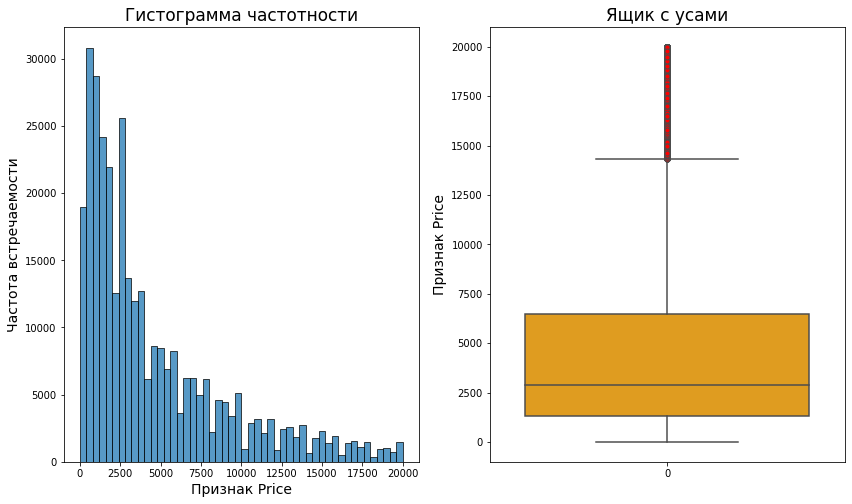


Статистические характеристики признака RegistrationYear


count    328017.000000
mean       2002.747236
std           6.525157
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Мода признака RegistrationYear: 2000



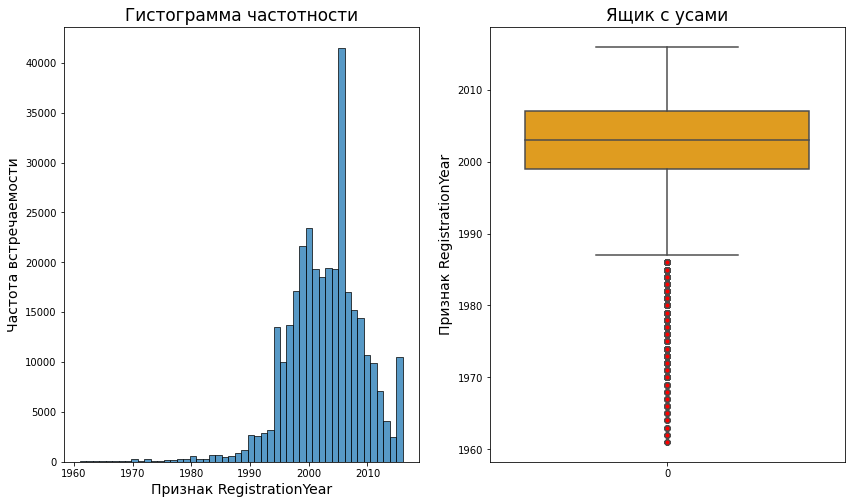


Статистические характеристики признака Power


count    328017.000000
mean        119.866748
std          48.246712
min          51.000000
25%          90.000000
50%         105.000000
75%         143.000000
max         349.000000
Name: Power, dtype: float64

Мода признака Power: 100



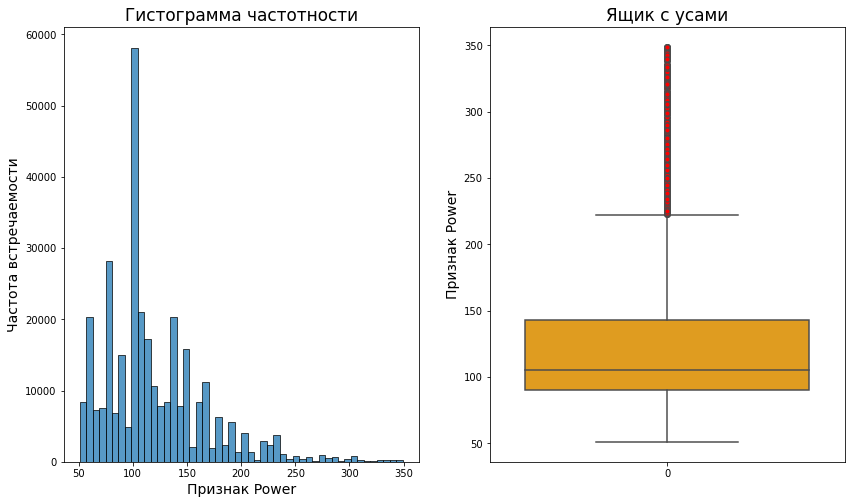


Статистические характеристики признака Kilometer


count    328017.000000
mean     128310.910715
std       37650.643718
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Мода признака Kilometer: 150000



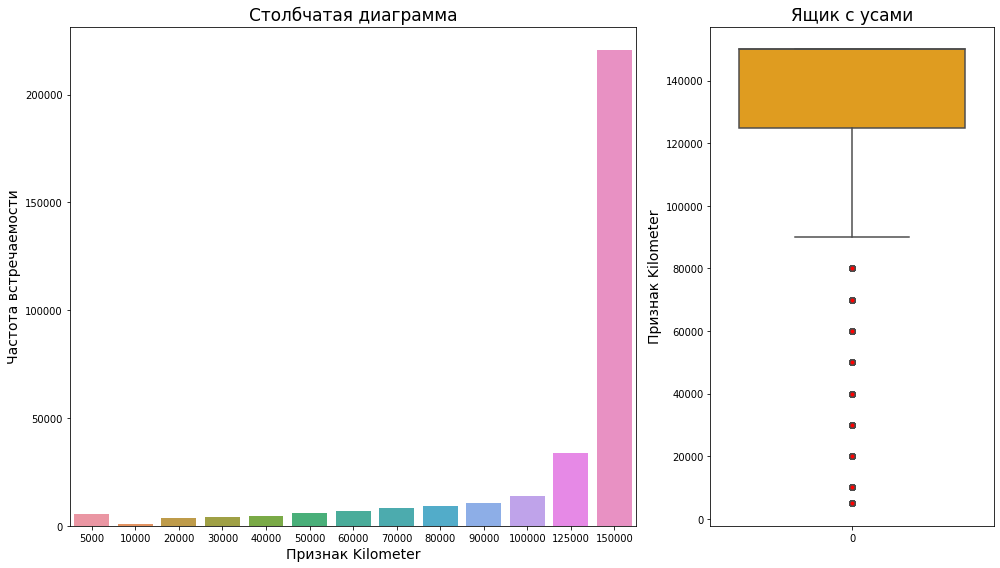

In [21]:
#Также значения в которых мощность двигателя равна 0 заменим на знаечние 100 л.с.
df.loc[df['Power'] == 0, 'Power'] = 100

#Срежем значения двигателей свыше 350 л.с. и ниже 50 л.с. (адекватный диапозон):
df = df.query('50 < Power < 350')

#Вызовем нашу функцию и посмотрим на изменения:
analysis_num(df, 50)

In [22]:
check()

Процент данных, который мы срезали: 7.44%


**Выводы по исследовательскому анализу количественных переменных:**

> Количественные данные теперь лежат в допустимом диапозоне, все аномалии - удалены

> Отфильтровали столбцы с годом и мощностью двигателся, теперь они совпадают с реальными

> **3.5% данных** от исходного числа мы потеряли при удалении аномальных значений в количественных переменных

#### Анализ категориальных признаков

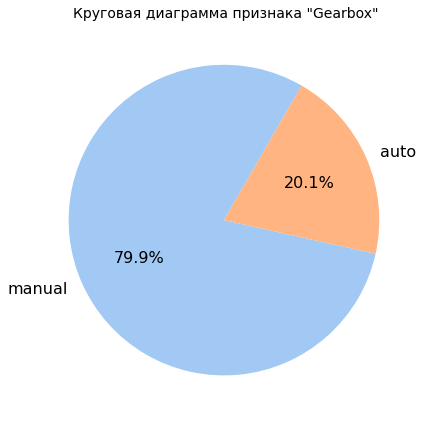

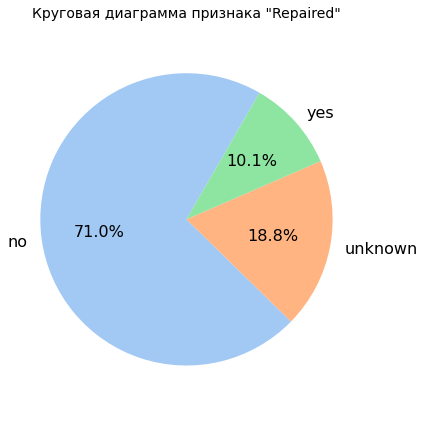

In [23]:
def analysis_cat(df):
    # Перебираем имена категориальных переменных в цикле
    for name in df[['Gearbox','Repaired']].columns.to_list():
        
        # Задаем цветовую палитру только для текущей функции
        with sns.axes_style("whitegrid"):
            colors = sns.color_palette("pastel")
        
        # Получаем value_counts и нормализуем значения
        values = df[name].value_counts()
        
        # Определяем отступы для мелких сегментов
        explode = [0.1 if v < 0.05 * values.sum() else 0 for v in values]
        
        # Строим круговые диаграммы
        fig, ax = plt.subplots(figsize=(6, 6))
        wedges, texts, autotexts = ax.pie(values, explode=explode, labels=values.index, autopct='%1.1f%%', 
                                          colors=colors, startangle=60, textprops={'fontsize': 12}, normalize=True)
        
        # Настройка текста для избежания наложения
        for text in texts + autotexts:
            text.set_fontsize(16)
            text.set_color('black')
        
        ax.set_title(f'Круговая диаграмма признака "{name}"', size=14)
        plt.axis('equal')  # Обеспечивает круговую диаграмму
        plt.tight_layout()
        plt.show()
        print()
        
analysis_cat(df)        

- Для остальных категориальных признаков выведем столбчатые диаграммы:

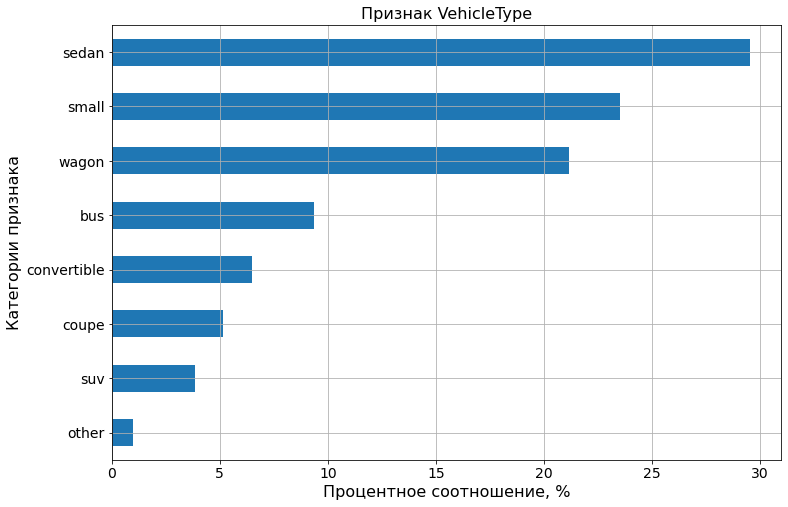

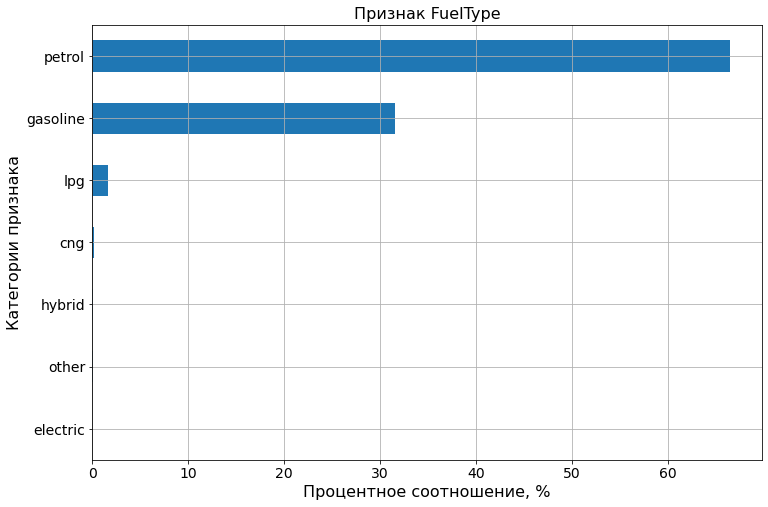

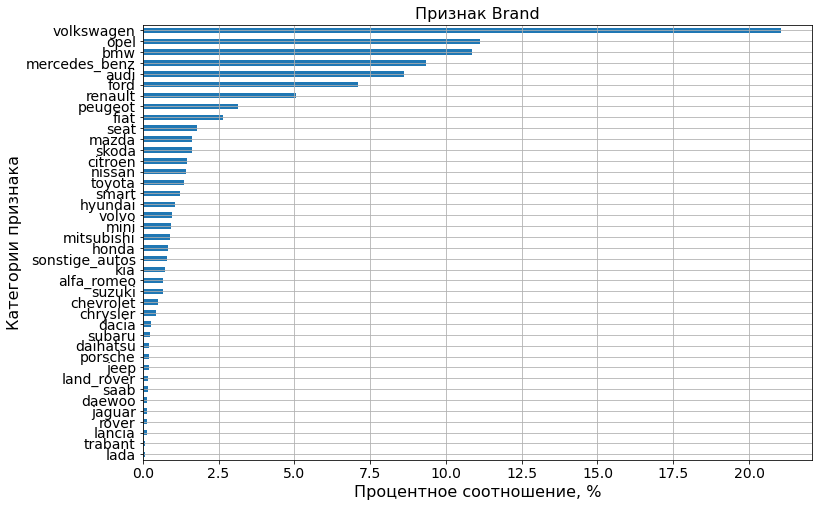

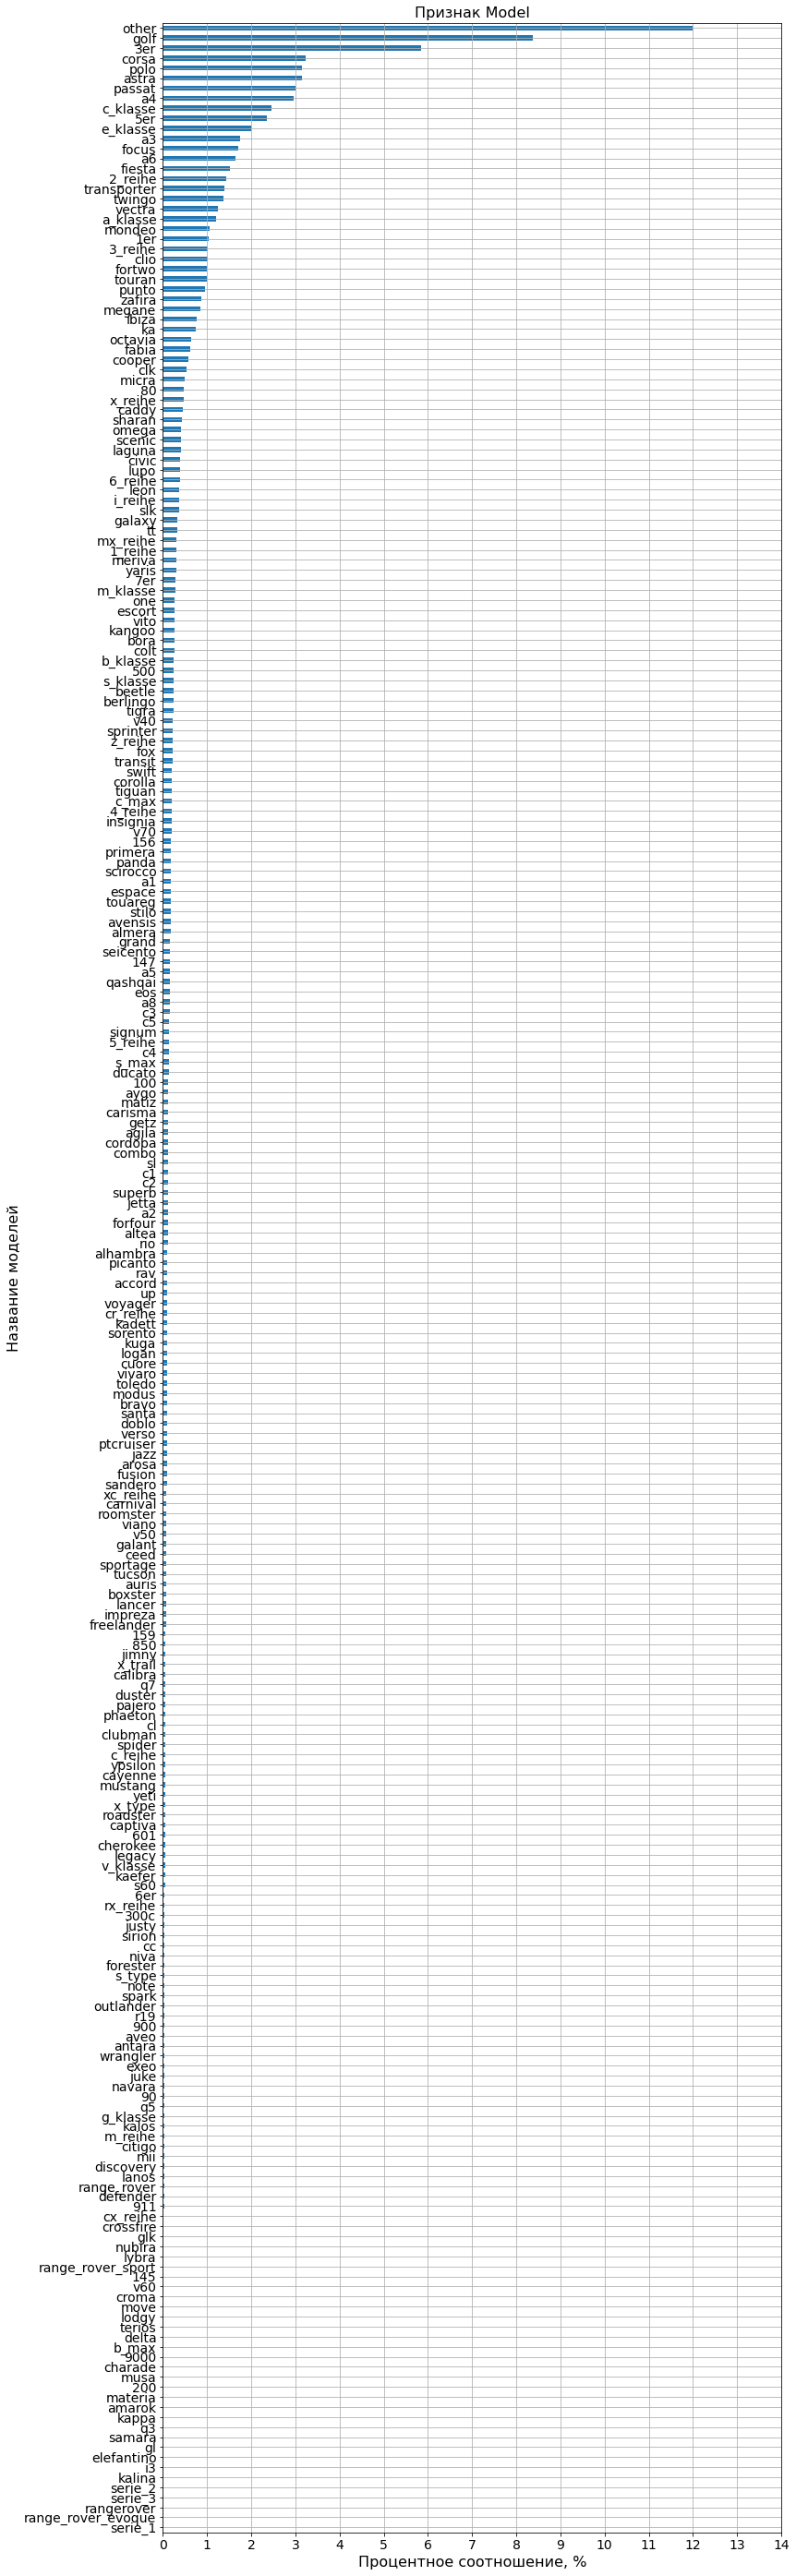

In [24]:
def analisys_cat_bar(df):
    for i in df[['VehicleType','FuelType','Brand']].columns.to_list():
        plt.figure(figsize=(12,8))
        k = df[i].value_counts(normalize=True)*100  #Приводим к долевым значениям
        k.sort_values(ascending=True).plot(kind='barh', fontsize=14)
        plt.title(f'Признак {i}', fontsize=16)
        plt.xlabel('Процентное соотношение, %', fontsize=16)
        plt.ylabel('Категории признака', fontsize=16)
        plt.grid()
        print()
        plt.show()
        print()
    
    #Отдельно построим график для признака Model:
    plt.figure(figsize=(12,50))
    k = df['Model'].value_counts(normalize=True)*100  #Приводим к долевым значениям
    k.sort_values(ascending=True).plot(kind='barh', fontsize=14)
    plt.title(f'Признак Model', fontsize=16)
    plt.xlabel('Процентное соотношение, %', fontsize=16)
    plt.ylabel('Название моделей', fontsize=16)
    plt.xticks(range(0, 15, 1))
    plt.grid()
    plt.show()   
        
#Вызываем функцию        
analisys_cat_bar(df)        

- Слишком много категорий в столбце Model (оставим пока без изменений)
- В столбцах FuelType и Brand - есть слишком маленькие знаечния, возьмем значения ниже 0.5% и добавим в отдельную категорию, которую назовем другие

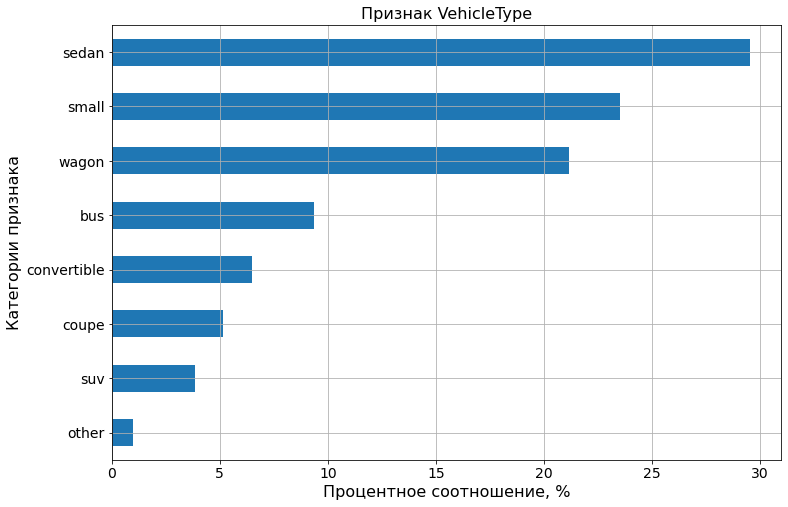

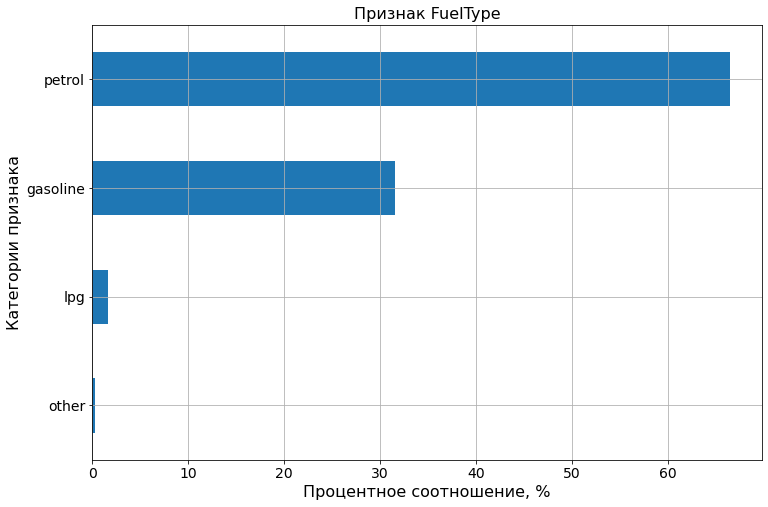

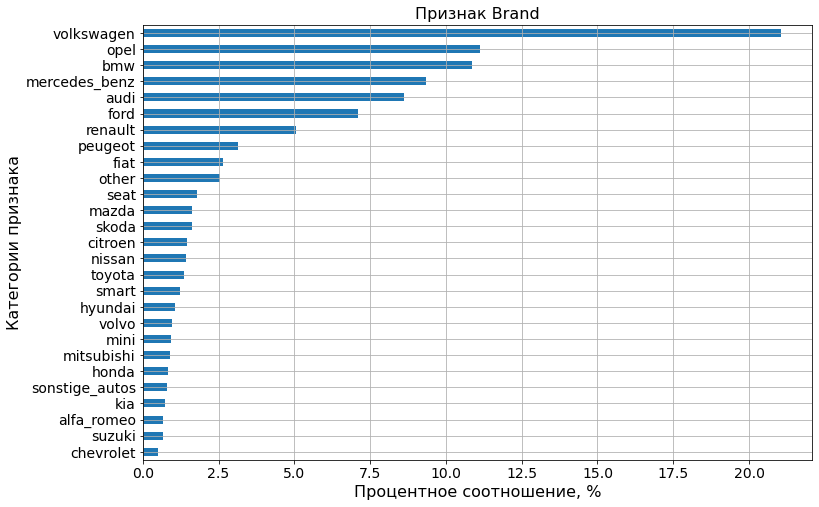

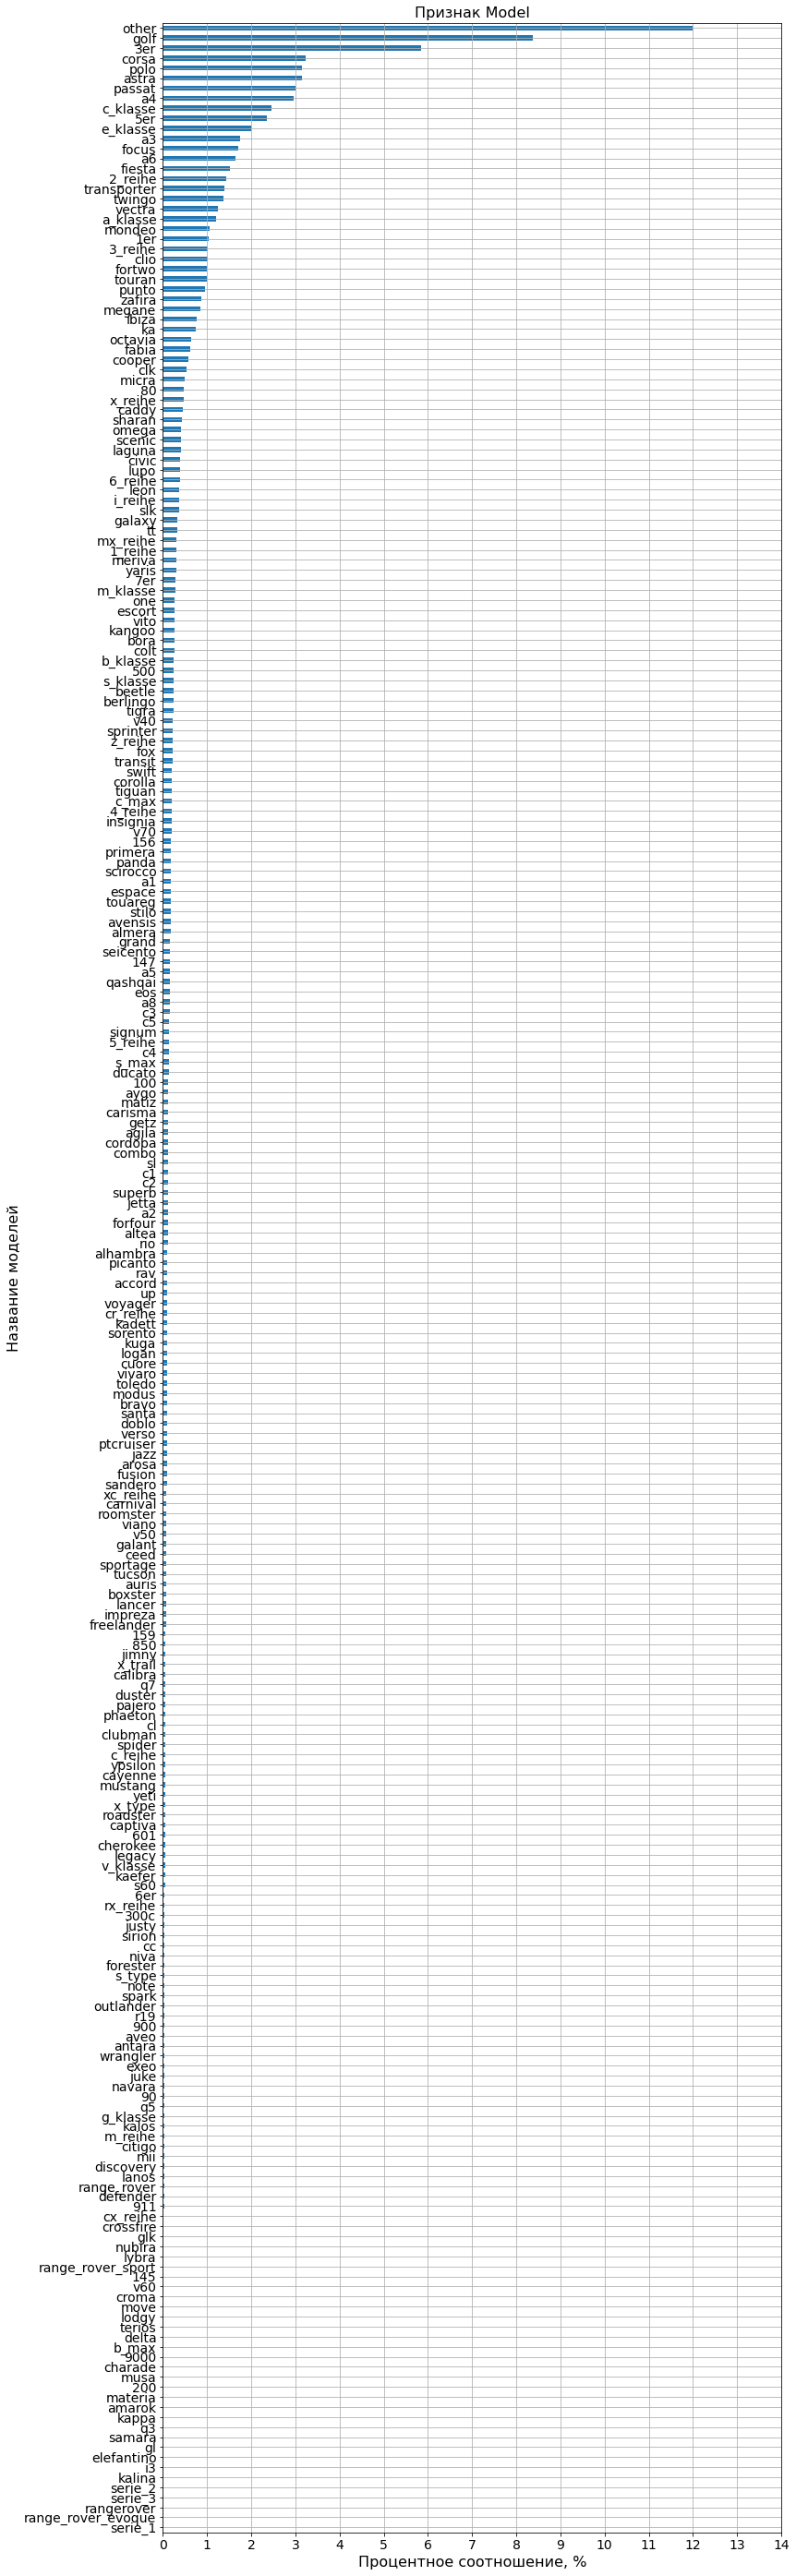

In [25]:
# Перебераем категории в цикле:
for name in ['FuelType', 'Brand']:
    counts = df[name].value_counts() #Вычисляем количество различных категорий    
    percentages = counts / len(df) * 100 # Вычисляем процентное соотношение каждой категории   
    threshold = 0.5 #Задаем порог
    mask = df[name].isin(percentages[percentages < threshold].index) # Определяем категории, которые составляют менее 1%
    df.loc[mask, name] = 'other' #Заменяем знаечние на другие
    
#Вызываем функцию и смотрим на наши графики:
analisys_cat_bar(df)    

**Выводы по исследовательскому анализу категориальных переменных:**

> Слишком большое количество категорий в столбцах Brand и Model, возможно их нужно будет сгруппировать или удалить конкретные поля

> Пока что не будем менять столбец Model, посмотрим как он будет коррелировать с другими входными признаками

> Остальные данные делятся в разумных соотношениях

<a id='section_5'></a>

### Проверка на дубликаты

In [26]:
df.duplicated().sum()

42608

- Все явные дубликаты требуется удалить

In [27]:
df = df.drop_duplicates()

#Проверка на удаление:
df.duplicated().sum()

0

- теперь посмотрим на неявные дубликаты

Выберем неизменчивые признаки:

***VehicleType, RegistrationYear, Gearbox, Model, Kilometer, FuelType, Brand, Price*** (Данные признаки неизменяемы для конкретного авто)

Признаки которые не будем учитывать при выявлении неявных дубликатов:

***Power*** - мощность двигателя может меняться в зависимости от конфугурации определенного авто. Т.е. может быть одна модель машины но с разной конфигурацией

***Repaired*** - не будет учитывать как одни и теже машины могли находиться в ремонте (да/нет) в зависимости от использования авто водителем при одинаковом сроке эксплуатации одинаковых авто

In [28]:
df.duplicated(subset=['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Price']).sum()

39361

- удалим неявные дубликаты

In [29]:
df = df.drop_duplicates(subset=['VehicleType', 
                                'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Price'])

#Выполним проверку удаления:
df.duplicated(subset=['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Price']).sum()

0

In [30]:
check()

Процент данных, который мы срезали: 30.57%


> Процент срезаных данных от перваночального превышает 10%, но оставлять дубли мы не можем, поэтому было принято решения потерять более 30.57% от первоначальных данных

<a id='section_6'></a>

### Корреляционный анализ

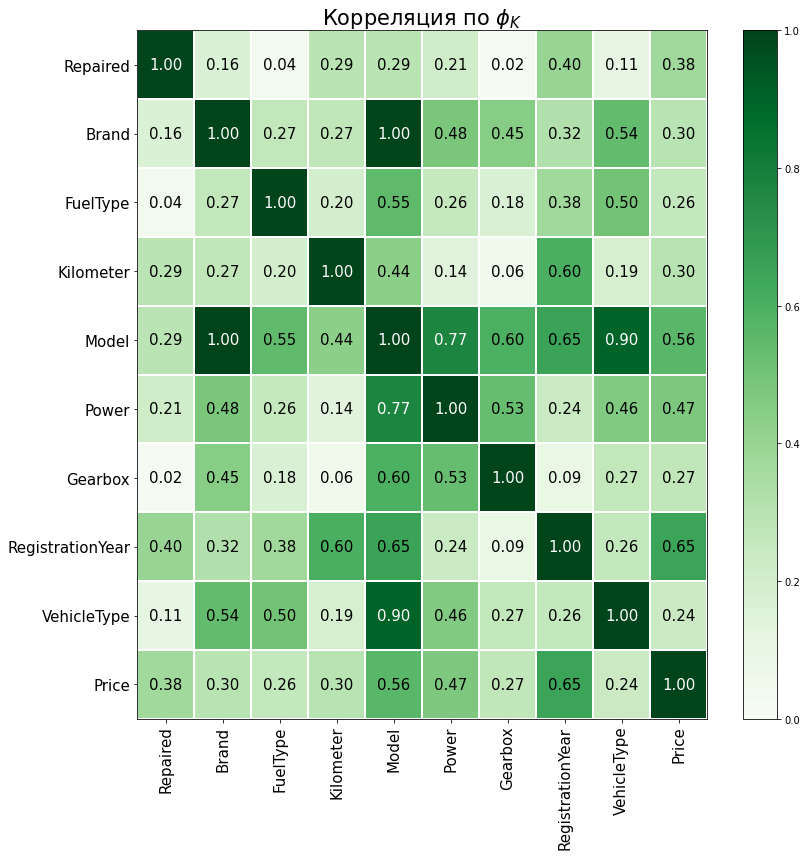

In [31]:
interval_cols = ['Price', 'Power', 'Kilometer']

#Считаем корреляции данных:
phik_overview = phik_matrix(df, interval_cols=interval_cols)

plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'Корреляция по $\phi_K$',
        fontsize_factor=1.5,
        figsize=(12, 12)
    )

> Наблюдается мультиколлинеарность между признаками Model и Brand, равная 1

Нужно принять решение об удалении одного из входных признаков. Будем руководствоваться большей корреляцией этих признаков с таргетов. Поскольку корреляция между таргетом и Model равна 0.56, а между Brand и таргет 0.3, принимаем решение удалить Brand.

Удалим данный столбец и посмотрим как изменилась корреляция:

In [32]:
#Удаляем стобец Brand
df = df.drop('Brand', axis=1)

## Обучение моделей

<a id='section_7'></a>

### Формирование выборок

In [33]:
#Отделяем входные и целевой признаки:
X = df.drop('Price', axis=1)
y = df['Price']

#Делим данные на обучающую и тестовую выборки:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

> Сделаем проверку размерностей

In [34]:
X_train.shape[0]  + X_test.shape[0] == df.shape[0]

True

<a id='section_8'></a>

### Создание пайплайна

In [35]:
#Создадим списпики для кодирования и масштабирования:

#Список для кодирования с помощью OneHotEncoder:
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

#Список для кодирования количественных перменных:
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

#Создадим паплайн предподготовки данных:

#SimpleImputer + OHE:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
 )

#Создаем общий пайплайн для подготовки данных:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),        
        ('num', StandardScaler(), num_columns)    
    ], 
    remainder =  'passthrough'
)

data_preprocessor

#Создаем финальный пайплайн, в котором будем перебирать методы масштабирования и различные модели:

pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

#Вызовем финальный пайплайн и посмотрим что получилось:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('models', LinearRegression())])

<a id='section_9'></a>

### Обучение моделей

#### Модель линейной регрессии

In [36]:
#Создадим свою метрику:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [37]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [LinearRegression()],          
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:
    
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,
    random_state=RANDOM_STATE,   
    scoring=rmse_scorer,
    n_iter=6,
    n_jobs=-1
)

# игнорирование предупреждений
warnings.filterwarnings("ignore")

In [38]:
%%time

#Обучение модели:
randomized_search.fit(X_train, y_train)

#Лучшая модель
model_linear = randomized_search.best_estimator_

#Лучшая метрика RMSE
best_score_linear_model = randomized_search.best_score_

CPU times: user 2min 32s, sys: 1min 19s, total: 3min 51s
Wall time: 3min 51s


In [39]:
start = time()

model_linear.fit(X_train, y_train) # обучение

end = time()

model_time_fit = (end-start)/60 #перевод в минуты

start = time()

model_linear.predict(X_train) # предсказание

end = time()

model_time_pred = (end-start)/60 #перевожу в минуты

print('Модель Линейной регрессии:')
print('-'*25)
print(f'Лучшая метрика RMSE на кросс-валидации: {abs(round(best_score_linear_model))}')
print(f'Время обучения модели: {round(model_time_fit, 4)}')
print(f'Время предсказания модели: {round(model_time_pred, 4)}')

Модель Линейной регрессии:
-------------------------
Лучшая метрика RMSE на кросс-валидации: 2838
Время обучения модели: 0.2883
Время предсказания модели: 0.02


#### Модель дерево регрессий

In [40]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(1,10),
     'models__min_samples_split': range(2,10),
     'models__min_samples_leaf': range(2,10),     
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:
    
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,    
    random_state=RANDOM_STATE,
    scoring=rmse_scorer,
    n_jobs=-1
)

In [41]:
%%time

#Обучение модели:
randomized_search.fit(X_train, y_train)

#Лучшая модель
model_tree = randomized_search.best_estimator_

#Лучшая метрика RMSE
best_score_tree_model = randomized_search.best_score_

CPU times: user 2min 15s, sys: 25.5 s, total: 2min 41s
Wall time: 2min 41s


In [42]:
start = time()

model_tree.fit(X_train, y_train) #обучение

end = time()

model_time_fit = (end-start)/60 #перевод в минуты

start = time()

model_tree.predict(X_train) #предсказание

end = time()

model_time_pred = (end-start)/60 #перевод в минуты

print('Модель Дерева регрессий:')
print('-'*25)
print(f'Лучшая метрика RMSE на кросс-валидации: {abs(round(best_score_tree_model))}')
print(f'Время обучения модели: {round(model_time_fit, 4)}')
print(f'Время предсказания модели: {round(model_time_pred, 4)}')

Модель Дерева регрессий:
-------------------------
Лучшая метрика RMSE на кросс-валидации: 2224
Время обучения модели: 0.0725
Время предсказания модели: 0.017


#### Модель CatBoost

In [43]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [CatBoostRegressor(logging_level='Silent', depth=5)],
     'models__iterations': [10, 20],
     'models__learning_rate': [0.1, 0.15, 0.2],    
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:
    
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,    
    random_state=RANDOM_STATE,
    scoring=rmse_scorer,
    n_jobs=-1
)

In [44]:
%%time

#Обучение модели:
randomized_search.fit(X_train, y_train)

#Лучшая модель
model_catboost = randomized_search.best_estimator_

#Лучшая метрика RMSE
best_score_catboost_model = randomized_search.best_score_

CPU times: user 10min 54s, sys: 21.9 s, total: 11min 16s
Wall time: 11min 40s


In [45]:
start = time()

model_catboost.fit(X_train, y_train) #обучение

end = time()

model_time_fit = (end-start)/60 #перевод в минуты

start = time()

model_catboost.predict(X_train) #предсказание

end = time()

model_time_pred = (end-start)/60 #перевод в минуты

print('Модель CatBoost:')
print('-'*25)
print(f'Лучшая метрика RMSE на кросс-валидации: {abs(round(best_score_catboost_model))}')
print(f'Время обучения модели: {round(model_time_fit, 4)}')
print(f'Время предсказания модели: {round(model_time_pred, 4)}')

Модель CatBoost:
-------------------------
Лучшая метрика RMSE на кросс-валидации: 2253
Время обучения модели: 0.2305
Время предсказания модели: 0.2029


#### Модель LightGBM

In [46]:
#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [LGBMRegressor(max_depth=5, n_estimators=20)],
     'models__num_leaves': [20, 30, 40],
     'models__learning_rate': [0.2, 0.25, 0.3],     
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:
    
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,    
    random_state=RANDOM_STATE,
    scoring=rmse_scorer,
    n_jobs=-1
)

In [47]:
%%time

#Обучение модели:
randomized_search.fit(X_train, y_train)

#Лучшая модель
model_lgbm = randomized_search.best_estimator_

#Лучшая метрика RMSE
best_score_lgbm_model = randomized_search.best_score_

CPU times: user 2min, sys: 24.4 s, total: 2min 24s
Wall time: 2min 24s


In [48]:
start = time()

model_lgbm.fit(X_train, y_train) #обучение

end = time()

model_time_fit = (end-start)/60 #перевод в минуты

start = time()

model_lgbm.predict(X_train) #предсказание

end = time()

model_time_pred = (end-start)/60 #перевод в минуты

print('Модель LightGBM:')
print('-'*25)
print(f'Лучшая метрика RMSE на кросс-валидации: {abs(round(best_score_lgbm_model))}')
print(f'Время обучения модели: {round(model_time_fit, 4)}')
print(f'Время предсказания модели: {round(model_time_pred, 4)}')

Модель LightGBM:
-------------------------
Лучшая метрика RMSE на кросс-валидации: 2062
Время обучения модели: 0.065
Время предсказания модели: 0.0218


## Анализ моделей

<a id='section_10'></a>

### Сравнение полученных моделей

| Модель МО | Метрика RMSE | Время обучения | Время предсказания |
|:------------:|:---------------:|:---------------:|:---------------:|
| LinearRegression | 2838 | 0.2883 | 0.02 |
| DecisionTreeRegressor | 2224 | 0.0725 | 0.017 |
| CatBoost | 2253 | 0.2305 | 0.2029 |
| LightGBM | 2062 | 0.065 | 0.0218 |


> **Лучшую метрику** имеет модель **LightGBM** 

> Самая **худшая метрика** у модели **LinearRegression**

> Самое **маленькое время обучения** имеет модель **LightGBM**

> Самое **долгое время обучения** имеет модель **LinearRegression**

По соотношению качества метрики и время обучения лучшая модель - это LightGBM. В своб очередь DecisionTreeRegressor имеет также неплохие показатели по качеству метрики и времени исполнения. Модель LinearRegression - имеет самое долгое время обучения. Модель CatBoost показал результаты хуже чем у LightGBM и DecisionTreeRegressor. Самое худшее значение метрики и время обучения показала модель LinearRegression

In [49]:
#Делаем предикты по лучшей модели:
y_pred = randomized_search.predict(X_test)

#Массив предиктов:
y_pred

array([ 2512.6208934 ,  1110.6689962 , 11029.51194592, ...,
        9141.26924737,  1924.54972508,  1894.16754284])

In [50]:
#Метрика RMSE на тестовых данных:
print(f'Значение RMSE на тестовых данных (лучшей модели): {round(root_mean_squared_error(y_pred, y_test))}')

Значение RMSE на тестовых данных (лучшей модели): 2068


> Модель **LightGBM** показала хорошие результаты метрики RMSE и на тестовых данных

## Вывод

**Постановленная задача**

Сервис по продаже автомобилей хочет создать приложение, которое будет предсказывать стоимость автомобиля. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- **качество предсказания**
- **время обучения модели**
- **время предсказания модели**

---

**Шаг №1. Подготовка данных**

Обработка исходного CSV-файла c данными об автомобилях. Исходный датафрейм содержит **16** признаков и **354369** наблюдений. 
Изначально провели подчистку данных. Удалили признаки, которые не являются ликвидными для обучения моделей МО. Это такие признаки как даты выгрузки и создания объявлений, региональные данные и т.д.

В данных имелось большое количество пропусков, решение об их заполнении и удалении принимались по ходу всей предобработки. 

В результате исследовательского анализа были срезанны аномальные значения, просмотренны допустипые интервалы и рассмотренны распределения всех количественных признаков. Также исследованы категориальные признаки и их долевые соотношения. 

Проведена проверка на дубли в обработаном датафрейме, по её результатам выявлено **43541** - дублей. Все дубли удалены, т.к. будут мешать при обучении модели.

Корреляционный анализ показал, что есть мультиколлинеарность между двумя признаками **Model** и **Brand**, равная **1**. Было решено удалить тот признак, который меньше коррелирует с таргетом, а именно бренд машины.

---

**Шаг №2. Обучение модели**

Для удобства перебора гиперпараметров и обработки пропусков (замена модами) для обучения модели был создан пайплайн. Для решения данной задачи о предсказании цены автомобиля было принято решения использовать такие модели как:

- Линейная регрессия

- Дерево регрессий
 
- CatBoost

- LightGBM

---

**Шаг №3. Анализ моделей**

Метрику для оценки качества модели использовали RMSE - которая показывает, на какое число в среднем отличается предсказанное знаечние от истинного. Также учитывалось время обучения, как и требовал заказчик. Результаты времени обучения и значения метрик проиллюстрированны в сводной таблице:

| Модель МО | Метрика RMSE | Время обучения | Время предсказания |
|:------------:|:---------------:|:---------------:|:---------------:|
| LinearRegression | 2838 | 0.2883 | 0.02 |
| DecisionTreeRegressor | 2224 | 0.0725 | 0.017 |
| CatBoost | 2253 | 0.2305 | 0.2029 |
| LightGBM | 2062 | 0.065 | 0.0218 |


По результатам моделирования лучшей моделью оказалась **LightGBM**, которая показала сравнительно хорошее время обучения и лучшее значение метрики **RMSE**

Данную модель мы использовали, для предсказания цены на тестовых данных, которая на тесте показала также хорошее значение метрики RMSE равное